Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

### Инструкция по выполнению проекта

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

### Описание данных

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

#  Подготовка

In [2]:
import numpy as np
import pandas as pd
import torch
import transformers
from tqdm import notebook
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from pymystem3 import Mystem
m = Mystem()
from sklearn.metrics import accuracy_score
import re
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv("/datasets/toxic_comments.csv")


In [3]:
data.head()

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
data.toxic.value_counts()

0    143346
1     16225
Name: toxic, dtype: int64

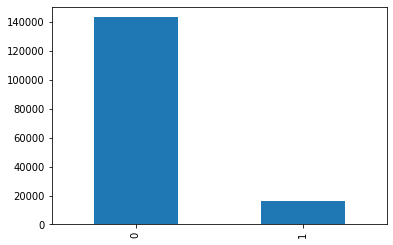

In [5]:
data.toxic.value_counts().plot(kind='bar')

Целевой признак имеет дисбаланс классов, негативных комментариев сильно меньше. Примерное соотношение 10:1

Для лучшей обработки текста, удалим из текста знаки пунктуации и стоп-слова и лемматезируем текст

In [6]:
def lemmatize(text):
    text = re.sub(r'[^a-zA-Z]', ' ', text)#уберем символы невходящие в состав слов
    return ''.join(m.lemmatize(" ".join(text.split()))) #вернем лематизироанный текст

In [7]:
data['text'] = data['text'].apply(lemmatize)

Посмотрим на результат лемматизации на примере 36 строчки

In [8]:
data.loc[36,'text'] 

'Mainland Asia includes the lower basin of China s Yangtze River as well as Korea But being specific is fine too I just found a citation for a more comprehensive DNA study by Hammer below rather than our generarizations and speculation so far Citation for Yayoi culture was brought to Japan by migrants from Korea who in turn trace their roots to southeast Asia south China DNA study by Hammer Describes the Yayoi migration from Korea based on the O SRY genes and other genes with close lineage haplogroups O M and O M Reiterates that the entire O haplogroup has been proposed to have a Southeast Asian origin Their definition of Southeast Asia includes southern China Then hypothesizes that the dispersals of Neolithic farmers from Southeast Asia also brought haplogroup O lineages to Korea and eventually to Japan In the concluding paragraph it states we propose that the Yayoi Y chromosomes descend from prehistoric farmers that had their origins in southeastern Asia perhaps going back to the ori

Лемматизированный текст не содержить цифр, знаков припинания и других символов. 

Разобьем датасет на трейн и тестовую выборки.

In [9]:
X = data.drop(["toxic"], axis=1)
Y = data["toxic"]
X_train, X_test,Y_train, Y_test  = train_test_split(X,Y,  test_size=0.20, random_state=12345)


In [10]:
X_train.head(3)

,text
45800,I have offered as well but he must do my map f...
94209,YOUR biased ORTHODOX VIEWS have no more merit ...
135210,Thank you very much for your quick respond and...


Проведем веткоризацию текстов совместно с очисткой от слов не несущих смысловой нагрузки 

In [11]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
 
corpus = X_train['text'].values.astype('U')
count_tf_idf = TfidfVectorizer(stop_words=stopwords) # < напишите код здесь >
tf_idf = count_tf_idf.fit_transform(corpus)

print("Размер матрицы:", tf_idf.shape)

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Размер матрицы: (127656, 148283)


In [12]:
corpus = X_test['text'].values.astype('U')  
tf_idf_test = count_tf_idf.transform(corpus)
print("Размер матрицы:", tf_idf_test.shape)

Размер матрицы: (31915, 148283)


# 2. Обучение

Перед нами стоит задача классификации. Так как в наших данных много признаков, а мы знаем, что ансамбль деревьев медленно работает с большим количеством признаков - не будем его использовать. 

### Логистическая регрессия 

In [13]:
model = LogisticRegression(class_weight='balanced')
model.fit(tf_idf, Y_train)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
from sklearn.model_selection import cross_val_score
final_score  =  sum(cross_val_score(model, tf_idf, Y_train,scoring='f1', cv=5))/5
print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: 0.7526627480692436


In [15]:
predicted_test = model.predict(tf_idf_test)
print('Значение F1-меры на тестовой   выборке: {:.2f}'.format(f1_score(Y_test, predicted_test)))

Значение F1-меры на тестовой   выборке: 0.76


### BERT

Данный вид векторизации текстов  отличается  от td idf. Нам придется заново векторизировать текст. Так же процесс занимает много времени, поэтому мы возьмем выборку в 10 000 строк. Посмотрим на урезанном датасете результативность метода. 

In [16]:
import torch
import transformers as ppb

In [17]:
df = pd.read_csv("/datasets/toxic_comments.csv").sample(10000, random_state=12345)

In [18]:
df.head(5)

,text,toxic
146790,Ahh shut the fuck up you douchebag sand nigger...,1
2941,"""\n\nREPLY: There is no such thing as Texas Co...",0
115087,"Reply\nHey, you could at least mention Jasenov...",0
48830,"Thats fine, there is no deadline ) chi?",0
136034,"""\n\nDYK nomination of Mustarabim\n Hello! You...",0


Скачаем предобученную модель для английского языка

In [19]:
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')

In [20]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

In [21]:

tokenized = df['text'].apply((lambda x: tokenizer.encode(x[:512], add_special_tokens=True)))

In [22]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0)

In [23]:
attention_mask.shape

(10000, 474)

In [24]:
import csv

Процесс  занял около 8 часов. Файл с эмбендингами записан в файл. код  построения эмбендингов  закоментирован.  

In [25]:
#batch_size = 20
#for i in notebook.tqdm(range(0,padded.shape[0] // batch_size)):
#        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
#        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
#        
#        with torch.no_grad():
#            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
#        
#        with open ('embeddings.csv', 'a') as fp:
#             for row in batch_embeddings[0][:,0,:].numpy():
#                csv.writer(fp, delimiter =",").writerow(row)

In [26]:
embeddings = pd.read_csv('embeddings.csv', header = None, prefix="var_")

In [27]:
embeddings.head(5)

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_758,var_759,var_760,var_761,var_762,var_763,var_764,var_765,var_766,var_767
0,-0.035164,0.295801,0.349051,-0.228358,-0.512623,-0.299728,0.820293,0.701220,0.227146,-0.418163,...,0.120036,-0.247062,0.141636,-0.366581,0.227262,0.402350,0.201533,-1.095685,0.555870,0.506105
1,0.342513,0.080022,-0.357067,0.166295,0.391793,0.025068,-0.101447,0.465087,-0.382985,0.031778,...,0.033765,-0.152756,0.330316,-0.170296,0.437426,0.742954,-0.032865,0.121617,0.471270,0.760185
2,0.166669,-0.126087,0.025481,-0.073916,-0.621769,-0.072550,0.552067,0.351537,0.015689,-0.334130,...,-0.215857,-0.494193,0.215269,-0.257622,0.183089,0.512602,-0.471190,-0.388262,0.745762,0.595034
3,-0.380757,-0.458215,0.208900,-0.456566,0.128633,-0.361518,0.427758,0.222339,0.260435,-0.397449,...,0.233554,-0.153517,0.124730,-0.376400,-0.068260,0.229872,-0.127671,-0.151037,0.724450,0.524436
4,0.078785,-0.038461,-0.038993,0.204492,-0.296699,-0.075463,0.260022,0.331149,0.042470,-0.235395,...,-0.102923,-0.121147,0.324418,-0.184331,0.484656,0.275844,-0.174141,-0.316595,0.294241,0.621862


И так мы получили векторы длиной в 768 признаков. 

In [28]:
train_features, test_features, train_target, test_target = train_test_split(
    embeddings, df['toxic'], test_size=0.5)

In [29]:
model = LogisticRegression(class_weight='balanced')
model.fit(train_features, train_target)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
predicted_test = model.predict(test_features)
print('Значение F1-меры на тестовой   выборке: {:.2f}'.format(f1_score(test_target, predicted_test)))

Значение F1-меры на тестовой   выборке: 0.64


# 3. Выводы

В рамках проекта были использованы два метода перевода текста в векторный формат td_idf и bert. Последний метод оказался чрезвычайно ресурсоемким.
Поэтому был звят небольшой фрагмент датасета, который не позволяет точно оценить преимущества и недостатки Bert. 
Метод td_idf позволил решить поставленную задачу - достигнут плановый показатель метрики f1  -  0.76